In [ ]:
#libraries to be used later ; #using python 3.8.10 env 


23074160640
2000376
11534
(11534, 63, 63, 63, 2)


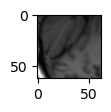

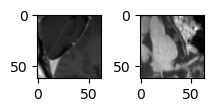

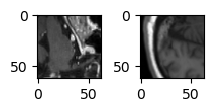

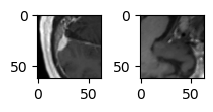

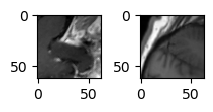

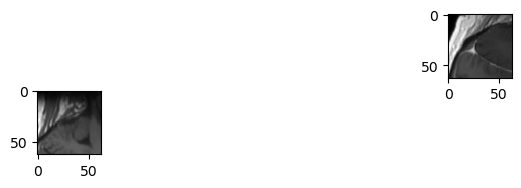

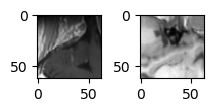

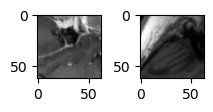

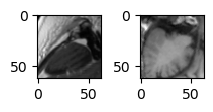

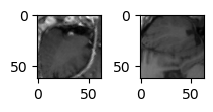

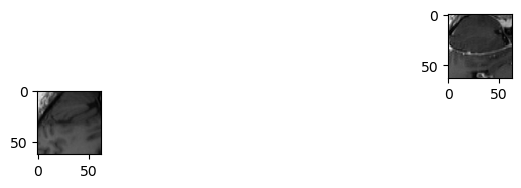

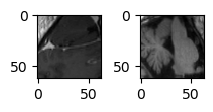

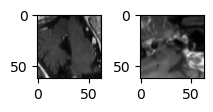

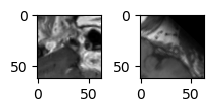

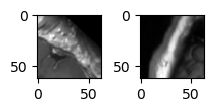

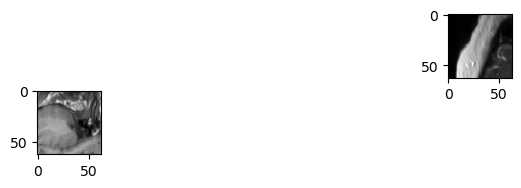

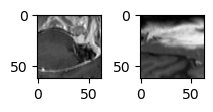

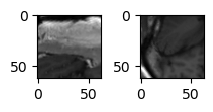

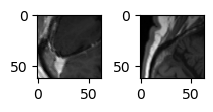

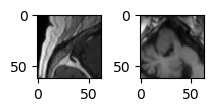

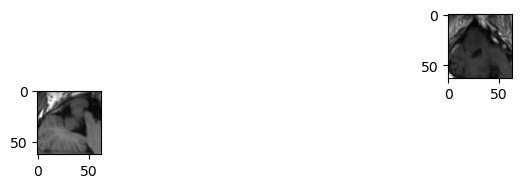

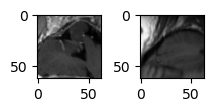

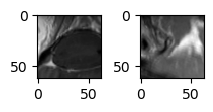

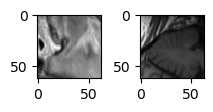

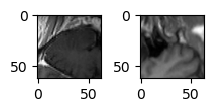

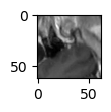

In [39]:
def main():
    radius_vector = np.array([31,31,31]) #radius vector of each patch
    dims = 1+2*radius_vector #dimension of each patch (63)
    frequency = 150 #sampling every 150 voxels
    num_rand= 5  #Number of randomly rotated patches
    sigma_angle = 30 # standard dev of rotation angle that is normally distrubute
    path_c3d='/home/ROBARTS/fogunsanya/graham/scratch/degad/derivatives/c3d' #convert 3d path
    #subject 19 only had 1.7GB (746 samples), subject 35 only had 17GB,  and subject 46 only has 21 GB
    #testing on sub-P002
    fname = f'{path_c3d}/sub-P046/sub-P046_degad_samples.dat'
    patch_vol = np.prod(dims)
    num_mods = 2 #number of diff image modalities 2 for gad and nongad 
    bpp = 4 #byte per pixel
    bps = bpp * num_mods * patch_vol# Bytes per each patch group

    file_size = os.path.getsize(fname) 
    num_samples = np.floor_divide(file_size,bps) # Number of samples
    print(file_size)
    print(bps)
    print(num_samples)

    arr_shape = (int(num_samples),dims[0],dims[1],dims[2],num_mods) #shape of whole sample size: number of patch groups, 3d dims of patch and number in each group (2)
    arr_all= np.memmap(fname,'float32','r',shape=arr_shape) #memory-map to a patches array stored in binary file with same dimensions, reading small segment at a time
    print(arr_shape)
    
    nrows=5
    ncols=5
    for i,randi in enumerate(randint(low=0,high=arr_shape[0],size=(nrows*ncols,))):#selecting random patches that will fit within size of plot
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(np.squeeze(arr_all[randi,:,:,20,0]),cmap='gray')#plotting nongad images
        plt.show()
        plt.subplot(nrows,ncols,i+1)
        plt.imshow(np.squeeze(arr_all[randi,:,:,20,1]),cmap='gray')#plotting gad images
    #picking a constant for x value produces a frontal slice, for y value produces 
    
main()

In [20]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
#from ipywidgets import interact
from sklearn.model_selection import train_test_split
import os
from glob import glob
import sys,fileinput
from numpy.random import randint
import nibabel as nib


In [31]:
# Import the libraries
#!git clone https://github.com/dhuy228/augmented-volumetric-image-generator
#!git clone https://github.com/imlab-uiip/lung-segmentation-3d.git 
#!mv augmented-volumetric-image-generator augmented # rename directory to augmented
#!mv lung-segmentation-3d unet # rename directory to unet
from augmented import generator
from unet.build_model import build_model 

In [36]:

from glob import glob
import sys,fileinput,io

path_c3d='/home/ROBARTS/fogunsanya/graham/scratch/degad/derivatives/c3d' #convert 3d path
samples_list = sorted(glob(f'{path_c3d}/*/*degad_samples.dat'))

list_sub = []
#appending subject names to list that have passed registration with either affine or rigid
finput1 = fileinput.input(sorted(glob("/home/ROBARTS/fogunsanya/graham/scratch/degad/scripts/updated/3b-passing_subjects_affine.txt")))
for f in finput1:
    list_sub.append(f.strip()) #appending passed subjects with affine transform to list
finput1.close()
finput2 = fileinput.input(sorted(glob("/home/ROBARTS/fogunsanya/graham/scratch/degad/scripts/updated/3b-passing_subjects_rigid.txt")))
for f in finput2:
    list_sub.append(f.strip()) #appending passed subjects with rigid transform to list
finput2.close()


list_sub.sort()
#from dataset of 23 images, separating into ~70% training, ~20% validation and ~10% testing
train_set = list_sub[0:16] #16 first subjects in training
val_set = list_sub[16:21] # 5 subjects in validation
test_set = list_sub[21:23] # 2 subjects in testing (same day scans)
for i in range(len(list_sub)):
    print(list_sub[i])


old_stdout = sys.stdout
new_stdout = io.StringIO() #creating string stream object
sys.stdout = new_stdout
print(*train_set,sep=',') #prints training dataset which is to be read by stream object
train = new_stdout.getvalue()
sys.stdout = old_stdout
train_set = '{'+train.rstrip()+'}' #making string linux compatible
print(train_set)
!cat {path_c3d}/{train_set}/*degad_samples.dat >> {path_c3d}/all_patches_train.dat #joins all subject files to the a combined training patch file


old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout
print(*val_set ,sep=',')
val = new_stdout.getvalue()
sys.stdout = old_stdout
val_set = '{'+val.rstrip()+'}'
print(val_set)
!cat {path_c3d}/{val_set}/*degad_samples.dat >> {path_c3d}/all_patches_val.dat #joins all subject files to the a combined validation patch file


sub-P002
sub-P005
sub-P007
sub-P009
sub-P010
sub-P014
sub-P017
sub-P018
sub-P019
sub-P030
sub-P031
sub-P032
sub-P034
sub-P035
sub-P038
sub-P040
sub-P044
sub-P045
sub-P046
sub-P051
sub-P052
sub-P053
sub-P055
{sub-P002,sub-P005,sub-P007,sub-P009,sub-P010,sub-P014,sub-P017,sub-P018,sub-P019,sub-P030,sub-P031,sub-P032,sub-P034,sub-P035,sub-P038,sub-P040}
cat: write error: Input/output error
cat: write error: Input/output error


"\nold_stdout = sys.stdout\nnew_stdout = io.StringIO()\nsys.stdout = new_stdout\nprint(*val_set ,sep=',')\nval = new_stdout.getvalue()\nsys.stdout = old_stdout\nval_set = '{'+val.rstrip()+'}'\nprint(val_set)\n!cat {path_c3d}/{val_set}/*degad_samples.dat >> {path_c3d}/all_patches_val.dat\n"

In [23]:
train_set = f'{path_c3d}/all_patches_train.dat'
val_set = f'{path_c3d}/all_patches_val.dat'

radius_vector = np.array([31,31,31]) #radius vector of each patch
dims = 1+2*radius_vector #dimension of each patch (63)
patch_vol = np.prod(dims) #volume of each patch
num_mods = 2 #number of diff image modalities 2 for gad and nongad 
bpp = 4 #byte per pixel
bps = bpp * num_mods * patch_vol# Bytes per each patch group

file_size_train = os.path.getsize(train_set) 
num_samples_train = np.floor_divide(file_size_train,bps) # Number of samples in training set
arr_shape_train = (int(num_samples_train),dims[0],dims[1],dims[2],num_mods) #shape of whole training sample : number of training patch groups, 3d dims of patch and number of modalities in each group (2)
arr_train= np.memmap(train_set,'float32','r',shape=arr_shape_train) #memory-map to a patches array stored in binary file with same dimensions, reading small segment at a time
print(file_size_train)
print(bps)
print(num_samples_train)
file_size_val = os.path.getsize(val_set) 
num_samples_val = np.floor_divide(file_size_val,bps) # Number of samples in validation set
arr_shape_val = (int(num_samples_val),dims[0],dims[1],dims[2],num_mods) #shape of whole validation  sample : number of validation patch groups, 3d dims of patch and number of modalities in each group (2)
arr_val= np.memmap(val_set,'float32','r',shape=arr_shape_val) #memory-map to a patches array stored in binary file with same dimensions, reading small segment at a time
print(file_size_val)
print(bps)
print(num_samples_val)

#each patch will undergo random rotation, random shift, random shear, elastic deform

60410429440
2000376
30199
412221440
2000376
206


In [40]:

model = build_model(arr_shape_val) # building u-net model with same shape as input patch
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #compiling model to run generaator

seed = 42 #seed to begin random value generator
bs = 32
ep = 50


# Create image data generators for both gad and nongad sets
aug_train = generator.customImageDataGenerator(
			rotation_range = 20, horizontal_flip= True, vertical_flip= True, shear_range = 0.2, zoom_range = 0.2, rescale=1./255) #generator for training dataset)

x_train = arr_train[:,:,:,:,1] #only selecting gad image channel
x_train_f = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1) #separated gad and nongad since only inputs 3d images
x_train_f = x_train_f.astype(np.uint8)

y_train = arr_train[:,:,:,:,0] #only selecting nongad image channel
y_train_f = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], y_train.shape[3], 1)
y_train_f = y_train_f.astype(np.uint8)


aug_val= generator.customImageDataGenerator(
			rotation_range = 20, horizontal_flip= True, vertical_flip= True, shear_range = 0.2, zoom_range = 0.2, rescale=1./255) #generator for validation dataset)

x_val = arr_train[:,:,:,:,1] #only selecting nongad image channel
x_val_f = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3], 1) #separated gad and nongad since only inputs 3d images
x_val_f = x_train_f.astype(np.uint8)

y_val = arr_train[:,:,:,:,0] #only selecting nongad image channel
y_val_f = y_train.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[2], y_train.shape[3], 1)
y_val_f = y_train_f.astype(np.uint8)



X_train_datagen = aug_train.flow(x_train_f, batch_size= bs, seed=seed) # set equal seed number
Y_train_datagen = aug_train.flow(y_train_f, batch_size = bs, seed=seed) # set equal seed number and generates iterator of batches of data that has been augmented
train_generator = zip(X_train_datagen, Y_train_datagen)

X_validation_datagen = aug_val.flow(x_val_f, batch_size= bs, seed=seed) # set equal seed number
Y_validation_datagen= aug_val.flow(y_val_f, batch_size= bs, seed=seed) # set equal seed number
validation_generator = zip(X_validation_datagen, Y_validation_datagen)


2023-01-06 13:48:39.796008: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-06 13:48:39.801469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (AFI-CBS-B11): /proc/driver/nvidia/version does not exist
2023-01-06 13:48:39.815700: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


ValueError: Input 0 of layer "max_pooling3d" is incompatible with the layer: expected ndim=5, found ndim=6. Full shape received: (None, 206, 63, 63, 63, 32)